In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import *

# define the a cubic toy model \psi_\theta
def phasemap(coeffs, x):
    return coeffs[0]*x**3 + coeffs[1]*x**2 + coeffs[2]*x

# define the inverse of above cubic toy model \psi_\-theta
def invphasemap(coeffs, x):
    if x>=0 and x<np.pi:
        return phasemap(coeffs, x+np.pi) - np.pi
    if x>=np.pi and x<2*np.pi:
        return phasemap(coeffs, x-np.pi) + np.pi

# coefficients (toy-model)
# a = 17/(6*np.pi**2)
# b = -33/(4*np.pi)
# c = 37/6

# Generate coefficients for phase map
# We require that the phase map go through (0,0), (2\pi, 2\pi)
def gen(p):
    '''compute coefficients for coeffgen matrix
    
    Function inputs:
    p: coordinate pair
    '''
    cubed = p[0]**3
    squared = p[0]**2
    linear = p[0]
    return (cubed, squared, linear)

def coeffgen(p1, p2, p3):
    '''generates coefficients that satisfy phase map conditions
    
    Function inputs:
    p1, p2, p3: three coordinate pairs
    '''
    row1 = [np.array(gen(p1))]
    row2 = [np.array(gen(p2))]
    row3 = [np.array(gen(p3))]
    coeffmatrix = np.concatenate((row1, row2, row3), axis=0)
    depvar = np.array((p1[1], p2[1], p3[1]))
    coeffs = np.linalg.solve(coeffmatrix, depvar)
    return (coeffs[0], coeffs[1], coeffs[2])

# Lyapunov exponent
def findlyap(coeffs):
    '''computes Lyapunov exponent for cubic toy model
    
    Function inputs:
    coeffs: 3-tuple of coefficients
    '''
    x = Symbol('x')
    f = phasemap(coeffs, x)
    f_prime = f.diff(x)
    f_prime = lambdify(x, f_prime)
    phis = np.linspace(0, 2*np.pi, num=100000)
    lyap = sum(np.log(abs(f_prime(phis))))*(1/len(phis))
    return lyap

In [47]:
# create initial orientations drawn randomly from a concentrated interval

import random

random.seed(0)

# width of the interval
width = 2*np.pi/100000
#width = 2*np.pi

# randomly pick a starting position
left = random.uniform(0,2*np.pi)
right = left + width

# draw n values from the interval
def draw_n(n):
    '''draw some number of random phases
    
    Function inputs:
    n: number of phases
    '''
    initial = [0]*n
    for i in range(n):
        initial[i] = random.uniform(left, right)
    return np.array(initial)

In [38]:
# send the set of orientations through the phase map
#    and waiting through the transient

def mapping(coeffs, orientations, counter):
    '''maps an ensemble of phases, by phasemap/invphasemap on even/odd iterations
    
    Function inputs:
    coeffs: 3-tuple of coefficients
    orientations: any ensemble of phases
    counter: 0 or 1 to keep track of even/odd iterations
    '''
    if counter == 0:
        tilted = [phasemap(coeffs, x) for x in orientations]
    elif counter == 1:
        tilted = [invphasemap(coeffs, x) for x in orientations]
    else:
        tilted = nan
    return np.array(tilted)

def translation(orientations, omega):
    '''translates the system of phases through a random, long time (noise)
    
    Functions inputs:
    orientations: any ensemble of phases
    omega: real eigenvalue of twist matrix (angular velocity)
    '''
    timestep = random.uniform(0, 2*np.pi/omega)
    pasttransient = orientations + omega*timestep
    return pasttransient

# a mapping (to psi) followed by a translation (to tilde phi)
#    gives a second set of orientations ready to undergo another
#    tilt in the external forcing

def iteration(coeffs, orientations, counter, omega):
    '''mapping (to psi) followed by a translation (to tilde phi)
    
    Function inputs:
    coeffs: 3-tuple of coefficients
    orientations: any ensemble of phases
    counter: 0 or 1 to keep track of even/odd iterations
    omega: real eigenvalue of twist matrix (angular velocity)
    '''
    final = translation(mapping(coeffs, orientations, counter), omega)
    final = [np.mod(final[i], 2*np.pi) for i in range(len(final))]
    return np.array(final)

In [39]:
# nearest neighbor estimate of information theoretic entropy

def closest(i, j, k):
    '''returns minimum difference with neighboring phases
    
    Function inputs:
    i: phase before
    j: phase
    k: phase after
    '''
    if j-i == 0 or k-j == 0:
        return 1e-15
    elif j-i <= k-j:
        return j-i
    else:
        return k-j

def sumterm(orientations):
    '''returns summation term in nearest neigbor entropy estimation formula
    
    Function inputs:
    orientations: array of phases
    '''
    sort = np.sort(orientations)
    acc = 0
    for n in range(len(orientations)):
        if n == 0:
            acc = acc + np.log(sort[1] - sort[0] + 1e-15)
        elif n == len(orientations) - 1:
            acc = acc + np.log(sort[-1] - sort[-2] + 1e-15)
        else:
            acc = acc + np.log(closest(sort[n-1], sort[n], sort[n+1]))
    return acc

def entropy(orientations):
    '''calculates entropy of an ensemble of objects
    
    Function inputs:
    orientations: array of phases
    '''
    m = len(orientations)
    euler = 0.57721566
    infoentropy = sumterm(orientations)/m + np.log(2*m-2) + euler
    return infoentropy

In [40]:
# evolves a system of n objects m times, and records the entropy at each step
#    for example: evolution(initial,1000) gives the entropy for a sequence of 1000
#    randomly timed tilts for 300 bodies
def evolution(coeffs, orientations, ntimes):
    '''evolves a system of objects by phasemap/invphase map on even/odd iterations respectively
    
    Function inputs:
    coeffs: 3-tuple of coefficients
    orientations: array of phases
    ntimes: number of iterations to evolve the system
    '''
    entropylist = []
    for i in range(ntimes+1):
        if np.mod(i,2) == 0:
            orientations = iteration(coeffs, orientations, 0, 0.5)
        else:
            orientations = iteration(coeffs, orientations, 1, 0.5)
        entropylist.append(entropy(orientations))
    del entropylist[0]
    return entropylist

In [48]:
import matplotlib.cm as cm

# set the number of iterations to evolve the system
iterations = 150

# set the number of objects to work with
numbodies = 500
initial = draw_n(numbodies)

# set the number of time sequences
numsequence = 30

# set the x values (iteration number)
x = np.linspace(1, iterations, num=iterations)

def plotresults(coeffs, orientations, niter, nseq):
    '''plots evolution of entropy for an ensemble of objects
    
    Function inputs:
    coeffs: 3-tuple of coefficients
    orientations: array of initial phases
    niter: number of iterations to evolve the system
    nseq: number of trials
    '''
    ys = [evolution(coeffs, orientations, niter) for i in range(nseq)]
    average = [np.mean([ys[j][i] for j in range(nseq)]) for i in range(niter)] # entropy at each step
    colors = cm.rainbow(np.linspace(0, 1, num=len(ys)))
    for y, col in zip(ys, colors):
        plt.scatter(x, y, s=1, color=col, alpha=0.5)
    plt.plot(x, average, c='black')
    lyaplabel = "$\lambda$ = " + str(round(findlyap(coeffs),3))
    plt.text(0.7, 0.1, lyaplabel, fontsize = 15, transform = plt.gca().transAxes)
    plt.xlabel('Iteration')
    plt.ylabel('Entropy')
    plt.show()

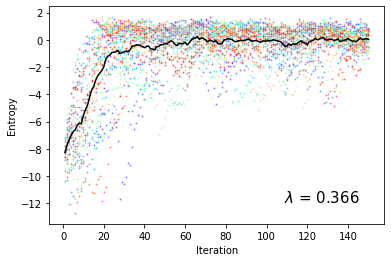

In [51]:
coefficients = coeffgen((2*np.pi,2*np.pi), (np.pi,3*np.pi/4), (3*np.pi/2, np.pi/4))
plotresults(coefficients,initial,iterations,numsequence)

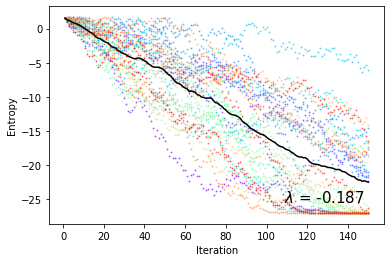

In [46]:
coefficients = coeffgen((2*np.pi,2*np.pi), (np.pi,np.pi), (3*np.pi/2, 5*np.pi/4))
plotresults(coefficients,initial,iterations,numsequence)